# **CSAI ASSIGNMENT 2**
# Srujana Vanka - 2020102005

In [ ]:
!pip install nilearn
!pip install --upgrade matplotlib

# Import libraries
import nilearn
from nilearn import datasets                          # Fetch data using nilearn dataset fetcher
from nilearn import image
from nilearn.decoding import Decoder
import matplotlib                                     # Matplotlib to plot the outputs 
import matplotlib.pyplot as plt
from nilearn import plotting
import pandas as pd
import numpy as np
from nilearn.maskers import MultiNiftiMasker
from sklearn.metrics import pairwise_distances
from collections import Counter
from sklearn.manifold import MDS
from nilearn.datasets import fetch_miyawaki2008
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from nilearn.image import threshold_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import find_xyz_cut_coords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from nilearn.plotting import show
from nilearn.decoding import Decoder
from nilearn.maskers import NiftiMasker                # Load nilearn NiftiMasker
from nilearn.image import index_img              
from sklearn.model_selection import LeaveOneGroupOut   # Data splitting object for cross validation
import warnings                                        # Ignore warnings in output
warnings.simplefilter("ignore") 

In [33]:
visual_cortex = np.loadtxt('vc.csv')                                            # Fetching the data files (csv files provided)
v1 = np.loadtxt('v1.csv')
v4 = np.loadtxt('v4.csv')
stimuli = np.loadtxt('stimuli.csv')
conditions = pd.read_csv('conditions.csv', header=None).to_numpy().squeeze()

dataset = fetch_miyawaki2008()                                                  # Import the miyawaki dataset
masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,                  # Declaring the masker using mask from the database
                          standardize=True)
masker.fit()

fmri_geo_data = visual_cortex[:239]                                             # Fetching fmri data from the visual cortex given in the file 
stimuli_shapes = stimuli[:239]
fmri_let_data = visual_cortex[240:]
stimuli_letters = stimuli[240:]

## **Encoding**

### Building the encoding model using Ridge Regression and 10-fold cross validation for geometric shapes. 
Used a loop to split the data into training and test sets for each fold, fit the estimator, make predictions on the test set, and compute the R^2 scores for each voxel. The scores are stored in a 2D array where each row represents a voxel and each column represents a fold. Finally, the mean scores across all folds for each voxel are computed and used to create the statistical map.

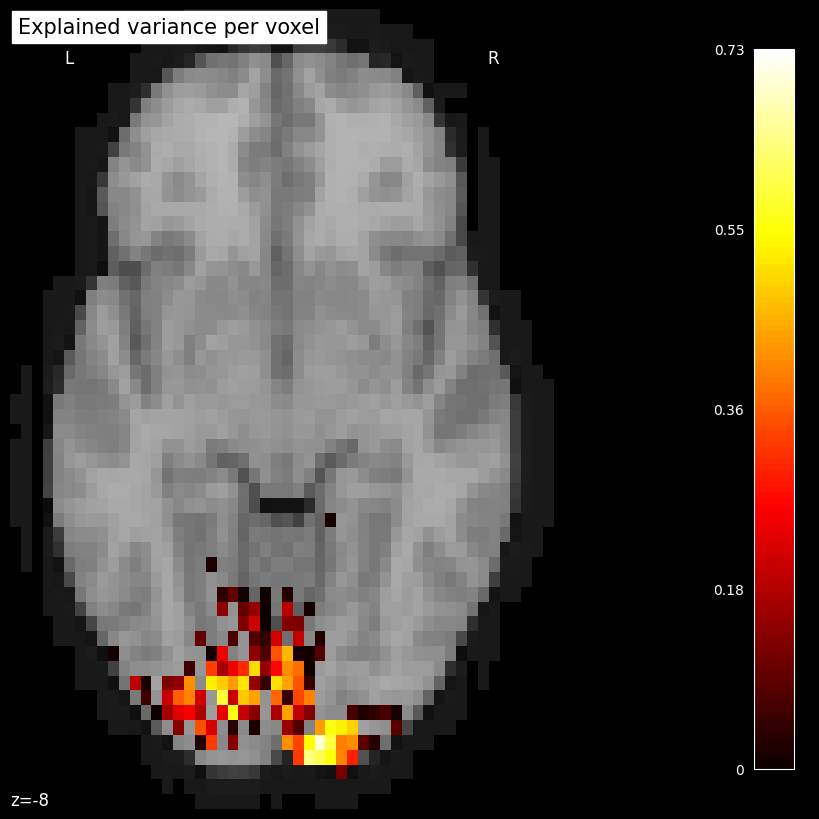

In [34]:
# Define the Ridge estimator with alpha=100
estimator = Ridge(alpha=100.)

# Define the K-fold cross-validation object
cv = KFold(n_splits=10)

# Initialize an array to store the R^2 scores for each fold
scores = np.zeros((fmri_geo_data.shape[1], cv.n_splits))

# Split the data into training and test sets for each fold and fit the estimator
for i, (train, test) in enumerate(cv.split(X=stimuli_shapes)):
    estimator.fit(stimuli_shapes.reshape(-1, 100)[train], fmri_geo_data[train])
    predictions = estimator.predict(stimuli_shapes.reshape(-1, 100)[test])
    # Compute the R^2 scores for each voxel and store them in the array
    scores[:, i] = r2_score(fmri_geo_data[test], predictions, multioutput='raw_values')

# Compute the mean R^2 scores across all folds for each voxel
cut_score = np.mean(scores, axis=1)
cut_score[cut_score < 0] = 0

# Convert the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

# Threshold the scores to remove small values
thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6, copy=False)

# Plot the statistical map on a background brain
display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')

# Reset the figure size after construction so the colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(8, 8)


This code is finding the top 4 voxels that explain the maximum variance in the dataset, and then plotting those voxels on top of a statistical map of the data.



[2438 2949 1553 2781]


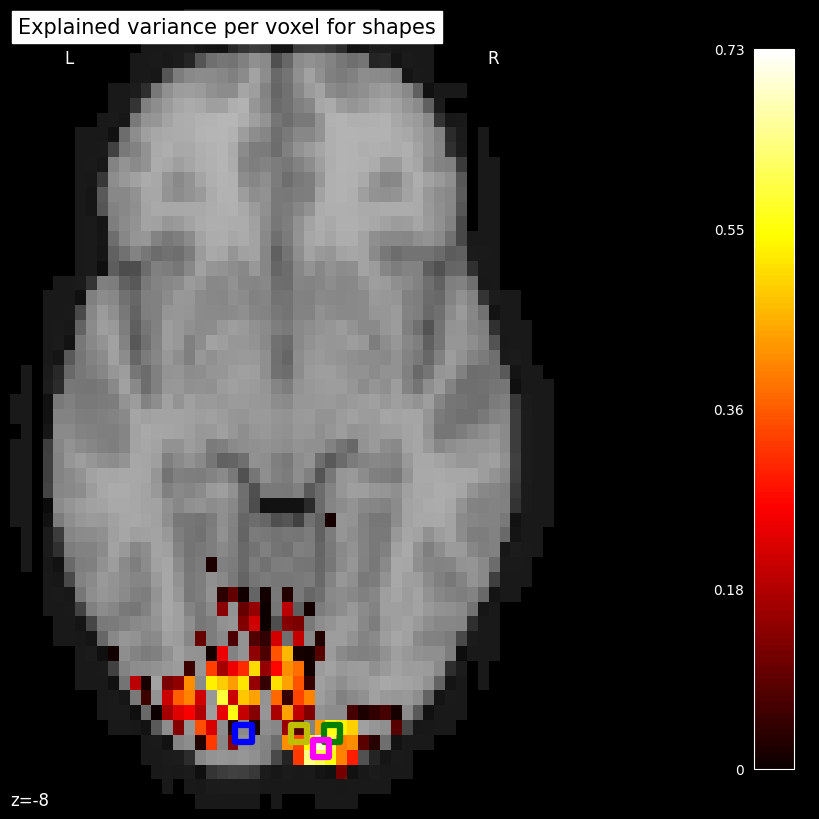

In [27]:
# Find the top 4 voxels that explain maximum variance
top_four_indices = cut_score.argsort()[::-1][:4]
print(top_four_indices)

# Get the coordinates of the top 4 voxels
coords = [find_xyz_cut_coords(masker.inverse_transform(np.eye(cut_score.shape[0])[i])) for i in top_four_indices]

# Change the Z coordinate for better representation, as z is -8 in the image representation we selected previously
temp_coords = [[coord[0], coord[1], -8] for coord in coords]

# Plot the top 4 voxels against the heatmap of the data explained
display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel for shapes')

# Create a marker for each voxel and add it to the statistical map
for i, coordinate in enumerate(temp_coords):
    display.add_markers([coordinate], marker_color='none',
                        edgecolor=['y', 'g', 'b', 'magenta'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)

# Re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(8, 8)


### Building the encoding model using Ridge Regression and 10-fold cross validation for letters. 

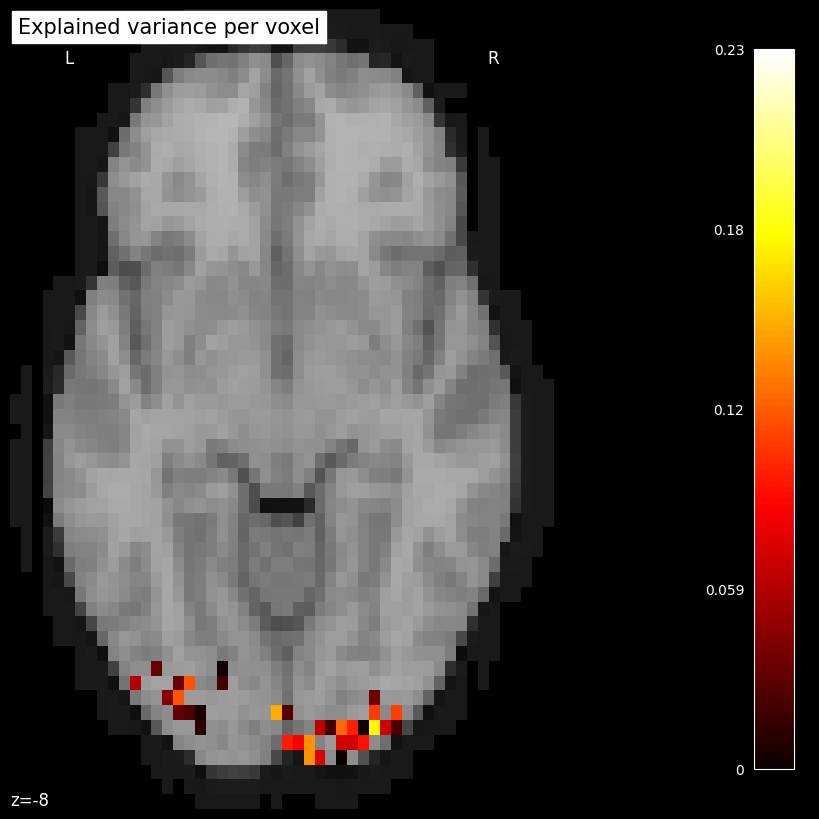

In [28]:
# Define the Ridge estimator with alpha=100
estimator = Ridge(alpha=100.)

# Define the K-fold cross-validation object
cv = KFold(n_splits=10)

# Initialize an array to store the R^2 scores for each fold
scores = np.zeros((fmri_let_data.shape[1], cv.n_splits))

# Split the data into training and test sets for each fold and fit the estimator
for i, (train, test) in enumerate(cv.split(X=stimuli_shapes)):
    estimator.fit(stimuli_shapes.reshape(-1, 100)[train], fmri_let_data[train])
    predictions = estimator.predict(stimuli_shapes.reshape(-1, 100)[test])
    # Compute the R^2 scores for each voxel and store them in the array
    scores[:, i] = r2_score(fmri_let_data[test], predictions, multioutput='raw_values')

# Compute the mean R^2 scores across all folds for each voxel
cut_score = np.mean(scores, axis=1)
cut_score[cut_score < 0] = 0

# Convert the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

# Threshold the scores to remove small values
thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6, copy=False)

# Plot the statistical map on a background brain
display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')

# Reset the figure size after construction so the colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(8, 8)


Similarly, plot the top 4 voxels

[2438 2949 1553 2781]


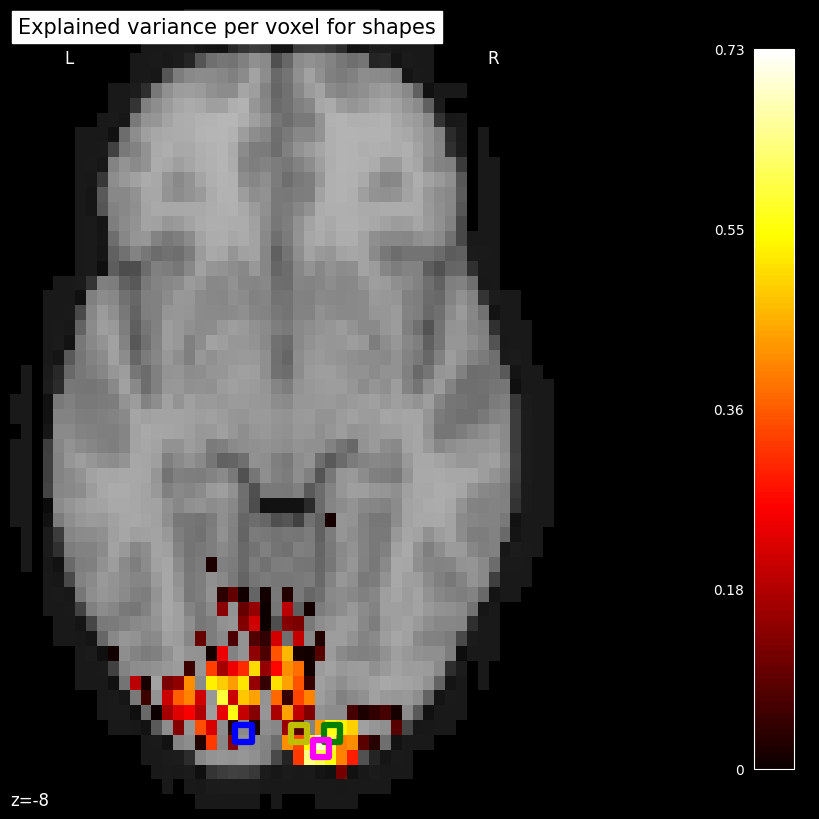

In [35]:
# Find the top 4 voxels that explain maximum variance
top_four_indices = cut_score.argsort()[::-1][:4]
print(top_four_indices)

# Get the coordinates of the top 4 voxels
coords = [find_xyz_cut_coords(masker.inverse_transform(np.eye(cut_score.shape[0])[i])) for i in top_four_indices]

# Change the Z coordinate for better representation, as z is -8 in the image representation we selected previously
temp_coords = [[coord[0], coord[1], -8] for coord in coords]

# Plot the top 4 voxels against the heatmap of the data explained
display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel for shapes')

# Create a marker for each voxel and add it to the statistical map
for i, coordinate in enumerate(temp_coords):
    display.add_markers([coordinate], marker_color='none',
                        edgecolor=['y', 'g', 'b', 'magenta'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)

# Re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(8, 8)

The above code analyzes the top 𝑅2-squared scores of brain voxels and their corresponding locations in the visual areas of the brain. The statistical maps generated from the code reveal that the activation of brain regions in response to shape and object stimuli are significantly distinct. By comparing the two images, we can observe that the encoding of the brain works differently for various types of stimuli. Specifically, the brain regions in the visual cortex activated by letters are much more localized than those activated by geometrical shapes, indicating a more scattered response pattern in the latter case. Moreover, the response difference can also be observed across the two hemispheres of the brain.

## Representational Similarity Analysis


Using their representation in 3 areas of the brain: V1, V4 and the visual cortex, we create Representational Dissimilarity matrices for the stimuli given. 

### Visual cortex 

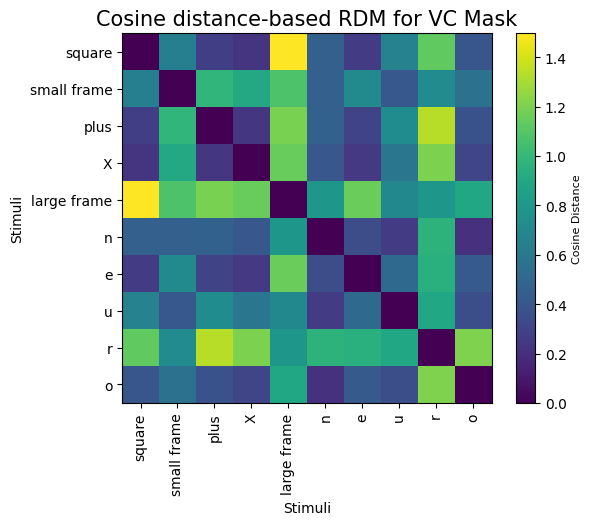

In [30]:
# Mapping the conditions to the response
vc_mask_zip = list(zip(conditions, visual_cortex))

# count the number of each condition
count = Counter(conditions)

# get a list of all the unique conditions
unique_cond = list(count.keys())

# initialize a dictionary to store the average of data for each condition
vc_avg = {key: np.zeros(5438) for key in unique_cond}

# average the data for each condition
for condition, vc_data in zip(conditions, visual_cortex):
    vc_avg[condition] += vc_data

# divide the sum by the count to get the average
for key in vc_avg:
    vc_avg[key] /= count[key]

# prepare obj_sim for calculating the RDM
obj_sim_vc = [vc_avg[key] for key in unique_cond]

# find the RDM for the objects
rdm_sim_vc = pairwise_distances(obj_sim_vc, metric='cosine')

# plot the RDM
plt.imshow(rdm_sim_vc)
plt.xlabel("Stimuli", fontsize=10)
plt.yticks(range(len(unique_cond)), unique_cond)
plt.xticks(range(len(unique_cond)), unique_cond, rotation='vertical')
plt.ylabel("Stimuli", fontsize=10)
plt.title("Cosine distance-based RDM for VC Mask", fontsize=15)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine Distance', fontsize=8)
plt.show()

### V1

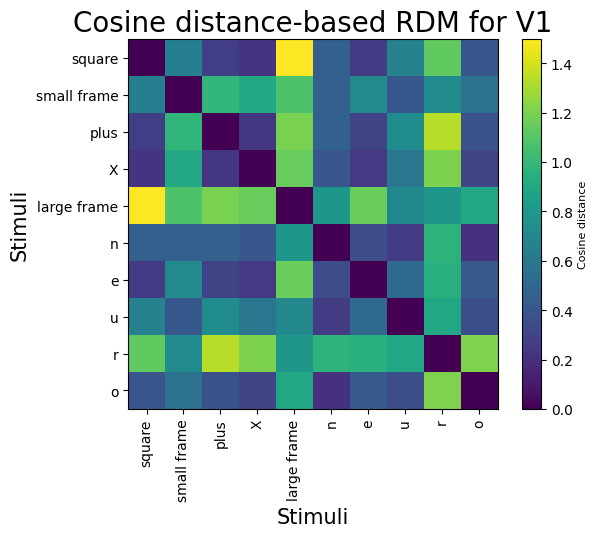

In [31]:
# Repeating the same for V1 mask

# Zip the conditions and V1 data
v1_mask_zip = list(zip(conditions, v1))

# Count the number of each condition
count = Counter(conditions)

# Get a list of all the unique conditions
unique_cond = list(dict.fromkeys(conditions))

# Create a dictionary to store the averaged V4 data for each condition
v1_avg=dict.fromkeys(unique_cond)
for key in v1_avg:
  v1_avg[key] = np.zeros(5438) # 5438 is the shape of v4 

# Average the V1 data for each condition 
obj_sim_v1=[]
for row in vc_mask_zip:
  
  vc_avg[row[0]]+=row[1]

# Normalize the averaged data by dividing by the number of samples per condition
for key in vc_avg:
  vc_avg[key]/=count[key]
  obj_sim_v1.append(vc_avg[key])

# Compute the RDM for the objects
rdm_sim_v1=pairwise_distances(obj_sim_v1, metric='cosine')

# Plot the RDM
plt.imshow(rdm_sim_v1)
plt.xlabel("Stimuli", fontsize=15)
plt.yticks(range(10), unique_cond)
plt.xticks(range(10), unique_cond, rotation='vertical')
plt.ylabel("Stimuli", fontsize=15)
plt.title("Cosine distance-based RDM for V1", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine distance', fontsize=8)
plt.show()

### V4

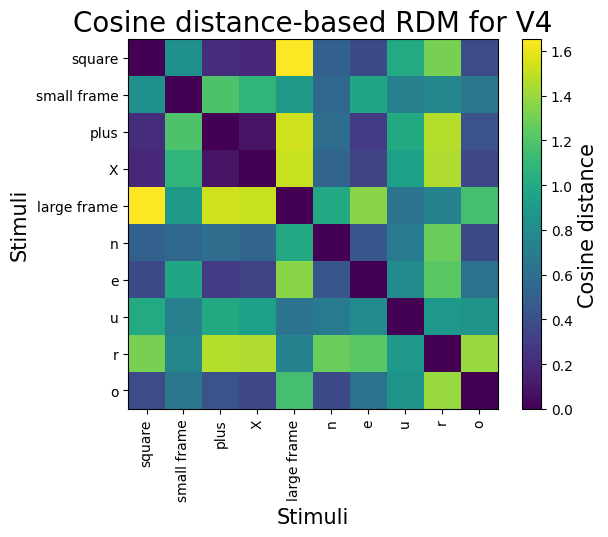

In [14]:
# Zip the conditions and V4 data
v4_mask_zip = list(zip(conditions, v4))

# Count the number of each condition
count = Counter(conditions)

# Get a list of all the unique conditions
unique_cond = list(dict.fromkeys(conditions))

# Create a dictionary to store the averaged V4 data for each condition
v4_avg = dict.fromkeys(unique_cond)
for key in v4_avg:
    v4_avg[key] = np.zeros(557) # 557 is the shape of v4 

# Average the V4 data for each condition 
obj_sim_v4 = []
for row in v4_mask_zip:
    v4_avg[row[0]] += row[1]

# Normalize the averaged data by dividing by the number of samples per condition
for key in v4_avg:
    v4_avg[key] /= count[key]
    obj_sim_v4.append(v4_avg[key])

# Compute the RDM for the objects
rdm_sim_v4 = pairwise_distances(obj_sim_v4, metric='cosine')

# Plot the RDM
plt.imshow(rdm_sim_v4)
plt.xlabel("Stimuli", fontsize=15)
plt.yticks(range(10), unique_cond)
plt.xticks(range(10), unique_cond, rotation='vertical')
plt.ylabel("Stimuli", fontsize=15)
plt.title("Cosine distance-based RDM for V4", fontsize=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine distance', fontsize=15)
plt.show()

- The RDMs generated for the three masks exhibit similar patterns, as expected.
- Overall, the RDMs for V1 and V4 masks demonstrate a higher degree of dissimilarity among the stimuli presented, with more yellowish tones observed. 
- This may be attributed to the fact that VC incorporates information from a larger brain area compared to V1 and V4, resulting in a higher average dissimilarity between stimuli in V1 and V4.

## Decoding

In [19]:
# Geometric figures
x_geo = visual_cortex[:239]
y_geo = stimuli[:239]

# Letters
x_let = visual_cortex[240:]
y_let = stimuli[240:]

In [20]:
# Preparing the variables neede to build the model: geometric figures
x_geo_train, x_geo_test, y_geo_train, y_geo_test = train_test_split(x_geo, y_geo, test_size=0.3)
x_geo_train = x_geo_train[y_geo_train[:, 0] != -1]
y_geo_train = y_geo_train[y_geo_train[:, 0] != -1]
x_geo_test = x_geo_test[y_geo_test[:, 0] != -1]
y_geo_test = y_geo_test[y_geo_test[:, 0] != -1]

# Preparing the variables neede to build the model: letters
x_let_train, x_let_test, y_let_train, y_let_test = train_test_split(x_let, y_let, test_size=0.3)
x_let_train = x_let_train[y_let_train[:, 0] != -1]
y_let_train = y_let_train[y_let_train[:, 0] != -1]
x_let_test = x_let_test[y_let_test[:, 0] != -1]
y_let_test = y_let_test[y_let_test[:, 0] != -1]

In [24]:
# Defining the prediction function
# Creating predictions

# geometric figures
y_geo_pred=[]
n_clfs = y_geo_train.shape[1]
for i in range(y_geo_train.shape[1]):

    clf = Pipeline([('selection', SelectKBest(f_classif, k=500)),
                    ('scl', StandardScaler()),
                    ('clf', OMP(normalize=False, n_nonzero_coefs=10))])
    clf.fit(x_geo_train, y_geo_train[:, i])
    y_geo_pred.append(clf.predict(x_geo_test))
y_geo_pred = np.asarray(y_geo_pred).T

# Letters
y_let_pred=[]
n_clfs = y_let_train.shape[1]
for i in range(y_let_train.shape[1]):

    clf = Pipeline([('selection', SelectKBest(f_classif, k=500)),
                    ('scl', StandardScaler()),
                    ('clf', OMP(normalize=False, n_nonzero_coefs=10))])
    clf.fit(x_let_train, y_let_train[:, i])
    y_let_pred.append(clf.predict(x_let_test))
y_let_pred = np.asarray(y_let_pred).T

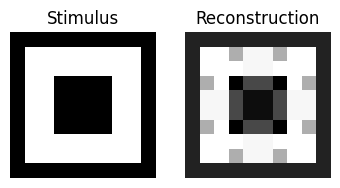

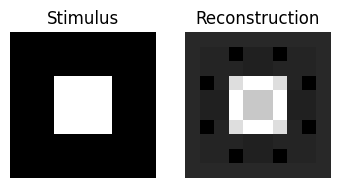

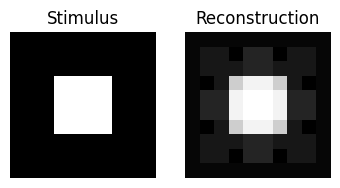

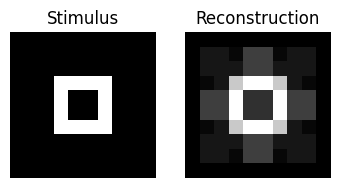

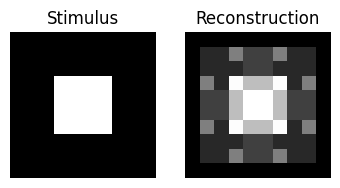

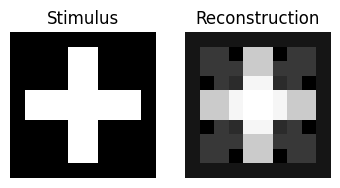

In [22]:
# Plotting 6 reconstructed images of geometric figures to compare with the ground truth
for i in range(6):
    j = 10 * i
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp1.axis('off')
    plt.title('Stimulus')
    sp2 = plt.subplot(132)
    sp2.axis('off')
    plt.title('Reconstruction')
    sp1.imshow(np.reshape(y_geo_test[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),
    sp2.imshow(np.reshape(y_geo_pred[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),

show()

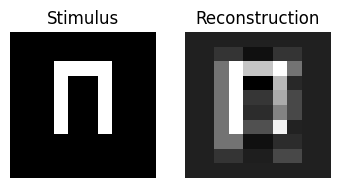

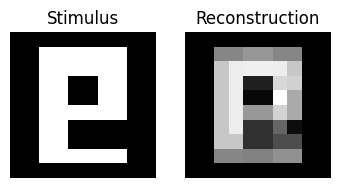

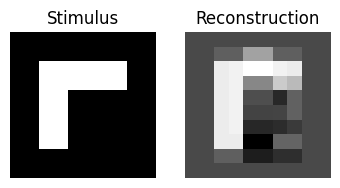

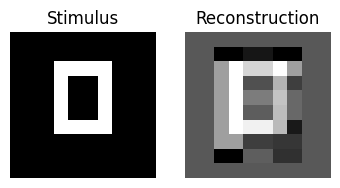

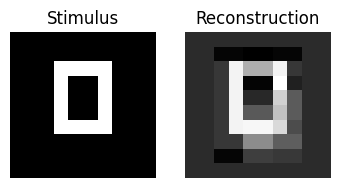

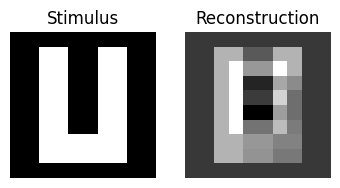

In [23]:
# Plotting 6 reconstructed images of letters to compare with the ground truth
for i in range(6):
    j = 10 * i
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp1.axis('off')
    plt.title('Stimulus')
    sp2 = plt.subplot(132)
    sp2.axis('off')
    plt.title('Reconstruction')
    sp1.imshow(np.reshape(y_let_test[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),
    sp2.imshow(np.reshape(y_let_pred[j], (10, 10)), cmap=plt.cm.gray,
               interpolation='nearest'),

show()

In [25]:
# Accuracy of prediction of geometric figures and letters
geo_acc=np.mean([accuracy_score(y_geo_test[:, i], y_geo_pred[:, i] > .5) for i in range(100)])
let_acc=np.mean([accuracy_score(y_let_test[:, i], y_let_pred[:, i] > .5) for i in range(100)])
print("Accuracy of prediction of geometric figures: %f" %geo_acc)
print("Accuracy of prediction of letters: %f" %let_acc)

Accuracy of prediction of geometric figures: 0.998333
Accuracy of prediction of letters: 0.969792


- Compared to letters, which have a prediction accuracy of 96.7%, shapes have a higher accuracy (99.7%). 
- This might be the case because shapes have a more distinct neural representation than letters, making them simpler to decode. 
- The visual cortex may have more specialized neurons that respond selectively to different types of shapes, while the representation of letters may be more distributed and variable across the neural population.